

> # **Исследование и формирование основного отчета по модели машинного обучения почта России**



## Загрузка данных

подключим удаленный жесткий диск, на нем хранится датасет с наименованием пересылаемых товаров который формировали при обработке признака mfi_name

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем необходимые библиотеки

In [ ]:
!pip install catboost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import catboost as cb
from catboost import cv
from catboost import CatBoostClassifier as CBclass
%matplotlib inline
import gc
import os


import datetime
import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  app.launch_new_instance()


подключили библиотеки, теперь загружаем датасет, который является тренировочный с заранее расшаренного жесткого диска (читается с colab)

In [ ]:
! [ ! -s "./train_dataset_train.csv" ] && curl -L -o train_dataset_train.csv "https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1qVRFpW_mq-A--xT26ds78APDjRquzrVB"

скачаем с открытых источникова именно с сайта почты России классификатор индексов и загрузим также в расшереный диск (читается с colab)

In [ ]:
! [ ! -s "./PIndx20.csv" ] && curl -L -o PIndx20.csv "https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1inuDJ_CRsWIUy_14It3iey2RlCqq3_6b"

In [ ]:
df_index = pd.read_csv("/content/PIndx20.csv", sep=";")

Подгружаем индексы

In [ ]:
df = pd.read_csv("/content/train_dataset_train.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


подгружаем тестовый датасет

In [ ]:
df_clust_mfi = pd.read_csv("/content/drive/MyDrive/dataset_pochta/file_train_words_clust.csv")

Подгрузили то что у нас получилось при обработке наименований посылок

In [ ]:
df['name_mfi'] = df['name_mfi'].str.lower()
df["name_mfi"] = df["name_mfi"].fillna(0)
df.loc[df['name_mfi'] == '0', 'name_mfi'] = 'no datum'
df['mfi_clust'] = df['name_mfi'].map(df_clust_mfi.set_index('index_id.1')['cluster'])
df['mfi_lang_lemm'] = df['name_mfi'].map(df_clust_mfi.set_index('index_id.1')['name_mfi_lemm'])
df['mfi_clust'] = df['mfi_clust'].astype('str')
df['mfi_lang_lemm'] = df["mfi_lang_lemm"].fillna(df['name_mfi'])

Соединим тестовый датасет и образуем у него новые признаки

- ['mfi_clust']  = признак автоматического категорирования +- отражает категории товаров
- mfi_lang_lemm = признак лемматизированых и переведенных товаров


Теперь поработаем с датафреймом индексов

In [ ]:
df_index.info()
df_index['date'] = pd.to_datetime(df_index['ACTDATE'], format='%d.%m.%Y')
c = '08.11.2022'
df_index['st'] = pd.to_datetime(c, format='%d.%m.%Y')
df_index['LifeDate'] =  (df_index['st'] - df_index ['date']).dt.days
print(df_index['LifeDate'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58005 entries, 0 to 58004
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   INDEX     58005 non-null  int64  
 1   OPSNAME   58005 non-null  object 
 2   OPSTYPE   58005 non-null  object 
 3   OPSSUBM   57918 non-null  float64
 4   REGION    57446 non-null  object 
 5   AUTONOM   560 non-null    object 
 6   AREA      37612 non-null  object 
 7   CITY      51842 non-null  object 
 8   CITY_1    2102 non-null   object 
 9   ACTDATE   58005 non-null  object 
 10  INDEXOLD  0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.9+ MB
0        4309
1        3913
2        2000
3         965
4        1027
         ... 
58000     616
58001     616
58002     616
58003     616
58004     613
Name: LifeDate, Length: 58005, dtype: int64


создадим новый признак - количество дней с момента последней актуализации информации, есть в общедоступном справочнике индексов

In [ ]:
del df_clust_mfi
gc.collect()

43

## Рассмотрим датасет по ближе



### применим исправления к Датасету







можем подружить датасеты через индекс операторов и заодно узнаем город местонахождения почтового отделения

In [ ]:
def obrabotka(df):
    global df_index # обьявим глобальной переменной датасет скачанный с почты россии, возьмем оттуда время с последней актуализации и город
    df["index_oper"] = pd.to_numeric(df["index_oper"], errors='coerce') # при этом пропущенные значения ставим 0
    df["index_oper"] = df["index_oper"].fillna(0)


    a = ['weight',  'transport_pay', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
         'total_qty_oper_login_0', 'total_qty_over_index_and_type', 'total_qty_over_index',  'index_oper', 'priority','class','mailtype','mailctg', 'mailrank', 'directctg','postmark','is_wrong_sndr_name',
     'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address']
    for i in a:
        df[i] = df[i].astype('int') # цифровые характеристики переводим из float в integer


    df.loc[df["weight"] == 0, 'weight'] = df["weight_mfi"] #возьмем информацию по весу от производителя. обределенную неизвестную часть точно заместим
    list_of_index = list(df.loc[df['index_oper'] == 0].groupby('total_qty_oper_login_0').sum().index)
    for i in list_of_index :
        df.loc[(df['index_oper'] == 0.0) & (df['total_qty_oper_login_0'] == i),'index_oper'] = list_of_index.index(i)+1

    df['city'] = df['index_oper'].map(df_index.set_index('INDEX')['REGION']) # введем переменную, отражающую регион, информацию возьмем со справочника скачанного на почте россии
    df['OPSNAME'] = df['index_oper'].map(df_index.set_index('INDEX')['OPSNAME'])# добавим столбец с нименованием отделения почтовой связи, т.к.
    df['actlife'] = df['index_oper'].map(df_index.set_index('INDEX')['LifeDate'])# добавим информацию о последней актуализации данных (в днях между сроком актуализации (взяли со справочника) и 8 ноября сего года, как раз когда я формировал эту функцию)


    df["actlife"] = pd.to_numeric(df["actlife"], errors='coerce') # при этом пропущенные значения последней актуализации данных ставим 0
    df["actlife"] = df["actlife"].fillna(0)



    df['city'] = df['city'].fillna(df['OPSNAME'])# заместим пропущеные значения региона названием отделения почтовой связи
    df = df.drop(['OPSNAME'], axis=1)# удалим название отделения почтовой связи
    df['city'] = df['city'].fillna('no_data')



    df = df.drop(['name_mfi'], axis=1)

    df.loc[df["is_in_yandex"] == '0', "is_in_yandex"] = 'N' #пропущенные значения заместим n, т.к. 0 - отсутствие значения следовательно по атрибутам задания тестового датасета понятно
    df.loc[df["is_privatecategory"] == '0', "is_privatecategory"] = 'N'

    df.loc[df["mailctg"] == -1, "mailctg"] = 1 # в соответствии с информацией с сайта почты россии категориии почтовых отправлений в отрицательно диапазоне нет. соответственно наиболее вероятно что была допущена ошибка
    #df = df.fillna(0)
    df['actlife'] = df['actlife'].astype('int')
    df['wrong'] = df['is_wrong_sndr_name'] + df['is_wrong_rcpn_name']+ df['is_wrong_phone_number'] + df['is_wrong_address'] # Добавим суммарный вес ошибки в доставке
    df['total_qty_over_type'] = df['total_qty_over_index_and_type'] -  df['total_qty_over_index'] #добавим разность между операторам
    #c = ['class','postmark', 'mailrank', 'mailtype','index_oper', 'priority','wrong','mailtype','mailctg', 'directctg'] #обьявим категорированные строки
    #for i in c:
    #    df[i] = df[i].astype('str')
    return df


обрабатываем массив

In [ ]:
df = obrabotka(df)
gc.collect()

79

In [ ]:
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 34 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   id                             int64 
 1   oper_type + oper_attr          object
 2   index_oper                     int64 
 3   type                           object
 4   priority                       int64 
 5   is_privatecategory             object
 6   class                          int64 
 7   is_in_yandex                   object
 8   is_return                      object
 9   weight                         int64 
 10  mailtype                       int64 
 11  mailctg                        int64 
 12  mailrank                       int64 
 13  directctg                      int64 
 14  transport_pay                  int64 
 15  postmark                       int64 
 16  weight_mfi                     int64 
 17  price_mfi                      int64 
 18  dist_qty_oper_login_1 

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,mfi_clust,mfi_lang_lemm,city,actlife,wrong,total_qty_over_type
0,6818780,1043_-1,628629,Участок,7503,N,0,Y,N,87,...,0,0,0,0,2.0,fishhook usb,НИЖНЕВАРТОВСК УОСП,1889,0,-7511770
1,9907176,1023_-1,102976,ММПО,7503,N,0,N,N,107,...,0,0,0,0,3.0,screen protector case q b case b db,МОСКВА,950,0,-4644213
2,3304275,1018_-1,620962,Цех,7503,N,0,Y,N,50,...,1,0,0,0,4.0,pendant necklace ring for woman necklace,СВЕРДЛОВСКАЯ ОБЛАСТЬ,4526,1,-46228711
3,9020937,1019_-1,344964,Цех,7503,N,0,Y,N,416,...,0,0,0,0,2.0,motorcycle signal lamp,РОСТОВСКАЯ ОБЛАСТЬ,4526,0,-16848126
4,3082311,1020_-1,629819,Участок,7503,N,0,Y,N,795,...,0,0,0,0,2.0,backpack,НОЯБРЬСК УООП,1884,0,-4374356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999995,9958614,1022_-1,102976,ММПО,7503,N,0,N,N,25,...,0,1,0,0,2.0,key chain,МОСКВА,950,1,-7705047
5999996,2234489,1022_-1,241963,Цех,7503,N,0,Y,N,83,...,0,0,0,0,2.0,doll,БРЯНСКАЯ ОБЛАСТЬ,4526,0,-13670585
5999997,4304572,1041_-1,102971,Цех,7506,N,0,N,N,1700,...,0,0,0,0,2.0,down jacket,МОСКВА,950,0,-14968387
5999998,6550634,1018_-1,102152,Цех,7506,N,0,N,N,269,...,1,0,0,0,nan,no datum,МОСКВА,5683,1,-19924768


In [ ]:
print(df.drop(['id'], axis = 1, inplace = False).duplicated().sum())

815346


при общем анализе мы видим что исключив столбец id имеем очень много дупликатов, поэтому посчитаем их (количество будет отражать количество повторяемых операций) и включим в новый признак

In [ ]:
df = df.drop(['id'], axis=1).groupby(df.drop(['id'], axis=1).columns.tolist(), as_index= False ).size()



посмотрим распределения количественных величин

In [ ]:
m = list(df.select_dtypes('int').columns)
print(m)

['index_oper', 'priority', 'class', 'weight', 'mailtype', 'mailctg', 'mailrank', 'directctg', 'transport_pay', 'postmark', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0', 'total_qty_over_index_and_type', 'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address', 'label', 'actlife', 'wrong', 'total_qty_over_type', 'size']


соединим индексы. определим города в которых есть место операции

Здесь попробуем

###анализ данных

index_oper


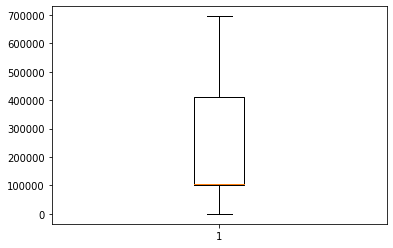

priority


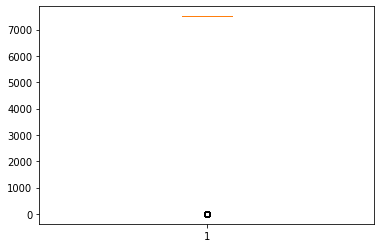

class


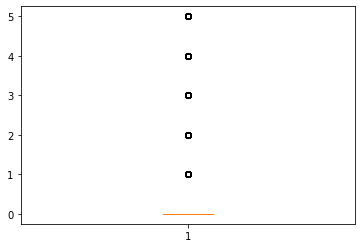

weight


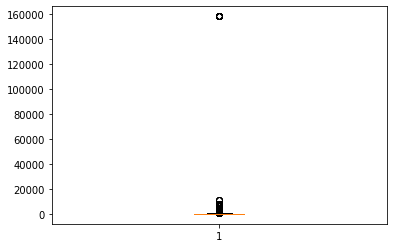

mailtype


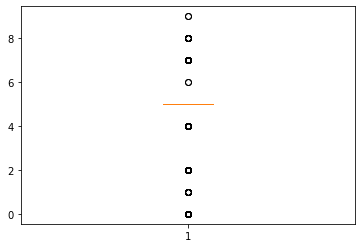

mailctg


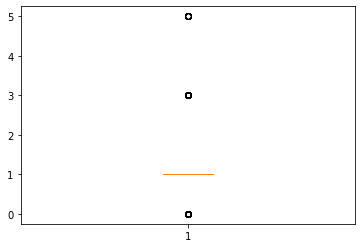

mailrank


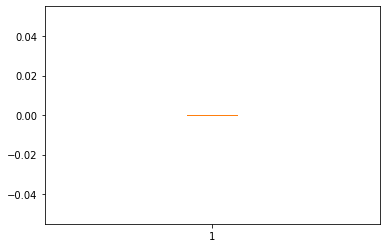

directctg


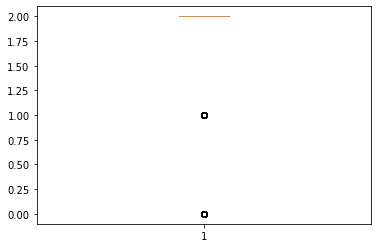

transport_pay


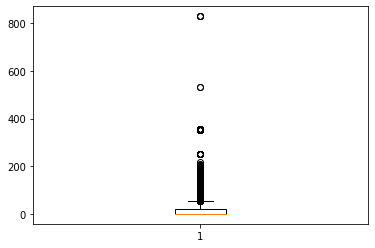

postmark


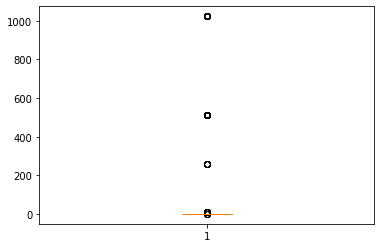

weight_mfi


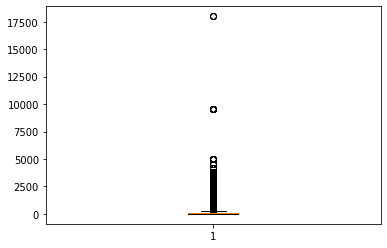

price_mfi


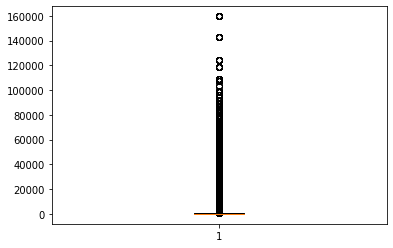

dist_qty_oper_login_1


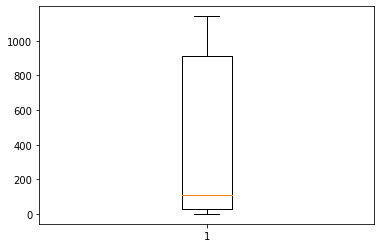

total_qty_oper_login_1


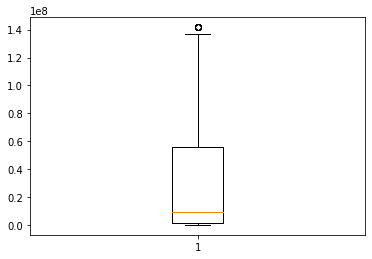

total_qty_oper_login_0


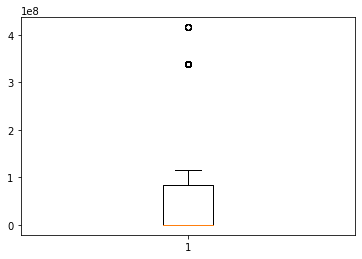

total_qty_over_index_and_type


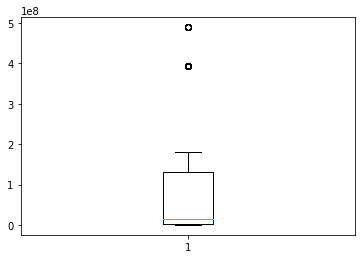

total_qty_over_index


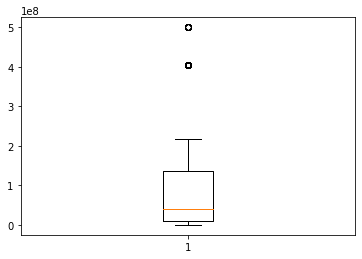

is_wrong_sndr_name


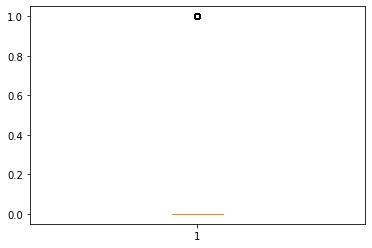

is_wrong_rcpn_name


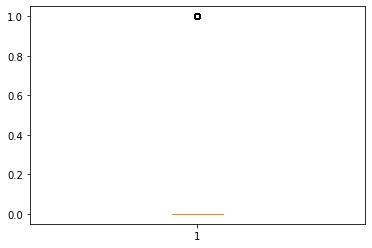

is_wrong_phone_number


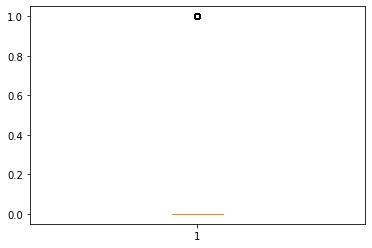

is_wrong_address


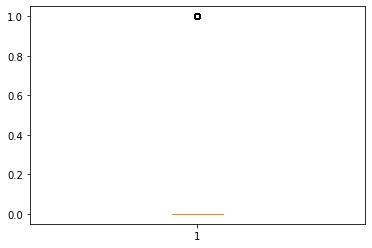

label


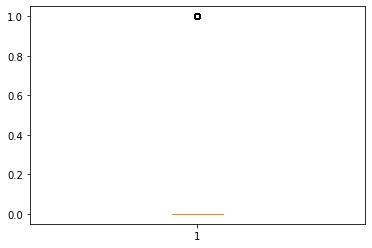

actlife


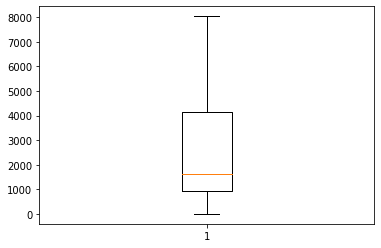

wrong


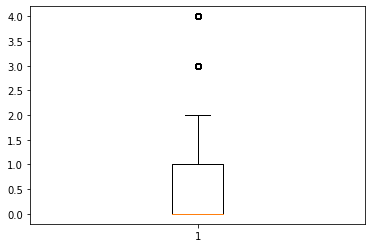

total_qty_over_type


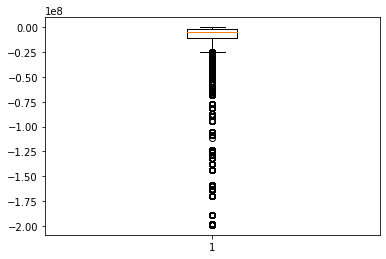

size


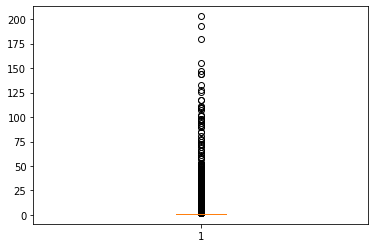

In [ ]:
for i in m:
    print(i)
    plt.boxplot(x=df[i])
    plt.show()




In [ ]:
df = df.query('weight < 40000')
df = df.query('transport_pay < 400')
df = df.query('weight_mfi < 8000')
df = df.query('price_mfi < 130000')

урезали выбросы с явными количественными переменными

## Выделим выборки

Обьединим список не нужных строк с списком строк типа object

In [ ]:
col_obj = df.select_dtypes('object').columns
print(col_obj)

Index(['oper_type + oper_attr', 'type', 'is_privatecategory', 'is_in_yandex',
       'is_return', 'mfi_clust', 'mfi_lang_lemm', 'city'],
      dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5184578 entries, 0 to 5184653
Data columns (total 34 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   index_oper                     int64 
 2   type                           object
 3   priority                       int64 
 4   is_privatecategory             object
 5   class                          int64 
 6   is_in_yandex                   object
 7   is_return                      object
 8   weight                         int64 
 9   mailtype                       int64 
 10  mailctg                        int64 
 11  mailrank                       int64 
 12  directctg                      int64 
 13  transport_pay                  int64 
 14  postmark                       int64 
 15  weight_mfi                     int64 
 16  price_mfi                      int64 
 17  dist_qty_oper_login_1          int64 
 18  total_qty_oper_login_1

In [ ]:
col_obj_2 = [ 'class', 'mailctg', 'directctg', 'mfi_clust' ,
  'city','wrong', 'size', 'type', 'is_privatecategory', 'is_in_yandex',
       'is_return','postmark', 'mailrank', 'index_oper', 'priority','mailtype','mailctg','is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number','is_wrong_address','wrong', 'size' ]


вытягиваем категорированные признаки

In [ ]:
for i in col_obj_2:
    df[i] = df[i].astype('category')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5184578 entries, 0 to 5184653
Data columns (total 34 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   oper_type + oper_attr          object  
 1   index_oper                     category
 2   type                           category
 3   priority                       category
 4   is_privatecategory             category
 5   class                          category
 6   is_in_yandex                   category
 7   is_return                      category
 8   weight                         int64   
 9   mailtype                       category
 10  mailctg                        category
 11  mailrank                       category
 12  directctg                      category
 13  transport_pay                  int64   
 14  postmark                       category
 15  weight_mfi                     int64   
 16  price_mfi                      int64   
 17  dist_qty_oper_login_1      

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5184578 entries, 0 to 5184653
Data columns (total 34 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   oper_type + oper_attr          object  
 1   index_oper                     category
 2   type                           category
 3   priority                       category
 4   is_privatecategory             category
 5   class                          category
 6   is_in_yandex                   category
 7   is_return                      category
 8   weight                         int64   
 9   mailtype                       category
 10  mailctg                        category
 11  mailrank                       category
 12  directctg                      category
 13  transport_pay                  int64   
 14  postmark                       category
 15  weight_mfi                     int64   
 16  price_mfi                      int64   
 17  dist_qty_oper_login_1      

In [ ]:
#,'is_wrong_sndr_name' ,'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address','mailrank','is_in_yandex', 'is_return','postmark','mailtype','is_privatecategory'

X = df.drop(['label','oper_type + oper_attr'], axis=1)
y = df["label"]
del df
# запуск сбора
gc.collect()

27855

In [ ]:
dataset = cb.Pool(X, y, cat_features=col_obj_2,text_features=['mfi_lang_lemm'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify = y)

del X, y
dataset_train = cb.Pool(X_train, y_train, cat_features=col_obj_2,text_features=['mfi_lang_lemm'])
dataset_test = cb.Pool(X_test, y_test, cat_features=col_obj_2,text_features=['mfi_lang_lemm'])
del X_train, X_test, y_train
gc.collect()

0

### подберем гиперпараметры

In [ ]:
clf = CBclass( iterations = 190,learning_rate = 0.4, loss_function = 'CrossEntropy', random_state=42, random_strength = 10, leaf_estimation_method = 'Newton', task_type="GPU", devices='0:1')

In [ ]:
#model = clf

grid = {'iterations': [10],#[500, 1000, 1200],
        'learning_rate': [0.4]}#,#[ 0.1, 0.3],
        #'depth': [6],#[ 6, 10],
        #'l2_leaf_reg':[5]}# [ 5, 7, 9]}

#grid_search_result = model.grid_search(grid,
 #                                      dataset,
  #                                    train_size = 0.8,
   #                                    shuffle = True,
    #                                   stratified = True,
     #                                  cv = 2)

## Обучение модели

In [ ]:
#display(grid_search_result.best_params_)

In [ ]:
#final_model = clf.set_params(grid)
clf.fit(dataset_train)
clf.save_model('content/catboost_1.json')
clf.save_model('content/catboost.bin')

## Оценка точности

In [ ]:
del X, y
gc.collect()

In [ ]:
from sklearn.metrics import f1_score, classification_report
t = pd.DataFrame({'y_true':y_test['label'],
                  'y_pred':final_model.predict(dataset_test),
                  'y_score':final_model.predict_proba(dataset_test)[:,1]})


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thr = roc_curve(t['y_true'], t['y_score'])

In [ ]:
roc = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})
roc.plot(x = 'fpr', y='tpr', figsize =(6,6), grid = True)

In [ ]:
roc['tpr - fpr'] = roc['tpr'] - roc['fpr']
roc.sort_values('tpr - fpr', ascending = False)['thr']
ocen = roc.sort_values('tpr - fpr', ascending = False,inplace = True)['thr']
value_p = ocen['thr', 0]

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score

score = roc_auc_score(y_test, pred, multi_class = "ovo" )
score_2 = recall_score(y_test, pred, average = "macro" )


final_score = (0.1 * score_2) + (0.9 * score)


In [ ]:
print('Recall 0.9752308243126359 0.9752308243126357 0.9752308243126357')
print('Recall 0.9748595796450011 0.9748595796450011 0.9748595796450011')
print("Recall", final_score, score_2, score)

Recall 0.9752308243126359 0.9752308243126357 0.9752308243126357
Recall 0.9748595796450011 0.9748595796450011 0.9748595796450011
Recall 0.8492786872274323 0.8492786872274322 0.8492786872274322


In [ ]:
del pred, X_test, y_test
gc.collect()

0

Попробуем разобрать тестовый файл


In [ ]:
! [ ! -s "./test_dataset_test.csv" ] && curl -L -o test_dataset_test.csv "https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1InOC4H4Qpu0eCvc0-DIgJ08LMzjnOya5"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  625M  100  625M    0     0   156M      0  0:00:03  0:00:03 --:--:--  174M


In [ ]:
df_test = pd.read_csv("content/test_dataset_test.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_clust_mfi = pd.read_csv("content/file_test_words_clust.csv")

In [ ]:


df_test['name_mfi'] = df_test['name_mfi'].str.lower()
df_test["name_mfi"] = df_test["name_mfi"].fillna(0)
df_test.loc[df_test['name_mfi'] == '0', 'name_mfi'] = 'no datum'
df_test['mfi_clust'] = df_test['name_mfi'].map(df_clust_mfi.set_index('index_id.1')['cluster'])
df_test['mfi_lang_lemm'] = df_test['name_mfi'].map(df_clust_mfi.set_index('index_id.1')['name_mfi_lemm'])
df_test['mfi_clust'] = df_test['mfi_clust'].astype('str')
df_test['mfi_lang_lemm'] = df_test["mfi_lang_lemm"].fillna(df_test['name_mfi'])

df_test = obrabotka(df_test)
gc.collect()

54

In [ ]:
del df_clust_mfi
gc.collect()
df_test_1 = df_test
df_test = df_test.drop(['id'], axis=1).groupby(df_test.drop(['id'], axis=1).columns.tolist (), as_index= False ). size ()
res = pd.merge(df_test, df_test_1, how='left', left_on=list(df_test.columns)[0:-1], right_on=list(df_test.columns)[0:-1])
display(res)

,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,is_wrong_phone_number,is_wrong_address,mfi_clust,mfi_lang_lemm,city,actlife,wrong,total_qty_over_type,size,id
0,0_-1,102973,ММПО,7503,N,0,N,N,63,5,...,0,0,2,processor e v,МОСКВА,950,0,-1039197,1,5341871
1,0_-1,102973,ММПО,7503,N,0,N,N,115,5,...,0,0,2,belt vz redbrown,МОСКВА,950,0,-1039197,1,5218956
2,0_-1,102973,ММПО,7503,N,0,N,N,180,7,...,0,0,8,bicycle light,МОСКВА,950,0,-391389,1,8546403
3,0_-1,102973,ММПО,7503,N,0,N,N,341,5,...,0,0,2,lamp tooth tube,МОСКВА,950,1,-1039197,1,9520850
4,0_-1,102973,ММПО,7503,N,0,N,N,448,5,...,1,0,2,shoulder bag,МОСКВА,950,2,-1039197,1,3189029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,9_-1,690951,Цех,7503,N,0,N,N,1586,5,...,0,0,20,pantie,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,7951997
3999996,9_-1,690951,Цех,7503,N,0,N,N,1594,5,...,0,0,2,die,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,1285672
3999997,9_-1,690951,Цех,7503,N,0,N,N,1595,5,...,0,0,2,shoulder bag,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,296884
3999998,9_-1,690951,Цех,7503,N,0,N,N,1604,5,...,0,0,2,sheet,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,6833383


In [ ]:
 res.isnull().sum()

oper_type + oper_attr            0
index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
mailrank                         0
directctg                        0
transport_pay                    0
postmark                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
mfi_clust                        0
mfi_lang_lemm                    0
city                

In [ ]:
display(res['id'].value_counts())
res = res.drop_duplicates()
display(res)

5341871    1
2031191    1
2158616    1
1314512    1
327499     1
          ..
8674316    1
3074694    1
1865021    1
493243     1
5625730    1
Name: id, Length: 4000000, dtype: int64

,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,is_wrong_phone_number,is_wrong_address,mfi_clust,mfi_lang_lemm,city,actlife,wrong,total_qty_over_type,size,id
0,0_-1,102973,ММПО,7503,N,0,N,N,63,5,...,0,0,2,processor e v,МОСКВА,950,0,-1039197,1,5341871
1,0_-1,102973,ММПО,7503,N,0,N,N,115,5,...,0,0,2,belt vz redbrown,МОСКВА,950,0,-1039197,1,5218956
2,0_-1,102973,ММПО,7503,N,0,N,N,180,7,...,0,0,8,bicycle light,МОСКВА,950,0,-391389,1,8546403
3,0_-1,102973,ММПО,7503,N,0,N,N,341,5,...,0,0,2,lamp tooth tube,МОСКВА,950,1,-1039197,1,9520850
4,0_-1,102973,ММПО,7503,N,0,N,N,448,5,...,1,0,2,shoulder bag,МОСКВА,950,2,-1039197,1,3189029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,9_-1,690951,Цех,7503,N,0,N,N,1586,5,...,0,0,20,pantie,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,7951997
3999996,9_-1,690951,Цех,7503,N,0,N,N,1594,5,...,0,0,2,die,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,1285672
3999997,9_-1,690951,Цех,7503,N,0,N,N,1595,5,...,0,0,2,shoulder bag,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,296884
3999998,9_-1,690951,Цех,7503,N,0,N,N,1604,5,...,0,0,2,sheet,ПРИМОРСКИЙ КРАЙ,2938,0,-1971,1,6833383


In [ ]:
for i in col_obj_2:
    res[i] = res[i].astype('category')
print(df.info())

In [ ]:
model = clf.load_model('content/catboost.bin', format='cbm')

In [ ]:


gc.collect()

In [ ]:
res['label'] = model.predict(res.drop(['id'], axis = 1, inplace = False))
res['label_score'] = model.predict_proba(res.drop(['id'], axis = 1, inplace = False))[:,1]
res['final_label'] = (res['label_score'] >= value_p) * 1


AttributeError: ignored

In [ ]:
res[['id', 'label']]

              id     label
0        5341871 -8.786956
1        5218956 -8.979240
2        8546403 -8.352996
3        9520850 -8.697261
4        3189029 -9.300814
...          ...       ...
3999995  7951997 -8.280688
3999996  1285672 -8.240862
3999997   296884 -8.180716
3999998  6833383 -8.152026
3999999  5625730 -8.452248

[4000000 rows x 2 columns]


In [ ]:
import csv
d = res[['id', 'final_label']]
d.to_csv('file_last.csv', sep = ',',index=False, line_terminator = '\n')

In [ ]:
test = pd.read_csv("file.csv")

In [ ]:
print(test)

              id  label
0        7815282      0
1        8443555      0
2        6352559      0
3        4921420      0
4        1420440      0
...          ...    ...
3999995  9030800      0
3999996  6275048      0
3999997  4701757      0
3999998   611153      0
3999999  7776936      0

[4000000 rows x 2 columns]


In [ ]:
cat_wine_imp = pd.Series(clf.get_feature_importance(),
                         res.drop(['id','label','is_wrong_sndr_name' ,'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address','mailrank','is_in_yandex', 'is_return','postmark','mailtype','is_privatecategory'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_wine_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()